In [26]:
from __future__ import annotations
import json, re
from pathlib import Path
from typing import List, Tuple
import pandas as pd

# ─────────── Locate project root ────────────
PROJECT_ROOT = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
OUTPUT_DIR   = PROJECT_ROOT / "outputs"
TABLE_DIR    = PROJECT_ROOT / "tables"
CSV_OUT      = TABLE_DIR / "press_results_f1.csv"

RAW_BENCHMARKS = ["gsm8k", "math", "olympiadbench", "omnimath"]
BENCH_DISPLAY  = {
    "gsm8k": "GSM8K",
    "math": "MATH",
    "olympiadbench": "Olympiad-Bench",
    "omnimath": "Omni-MATH",
}
RUN_RE = re.compile(r"_(?P<press>[^_]+)_r(?P<ratio>[0-9]*\.?[0-9]+)_q", re.IGNORECASE)

# ───────────────── Helpers ──────────────────
def extract_press_ratio(dirname: str) -> Tuple[str, float]:
    m = RUN_RE.search(dirname)
    if not m:
        raise ValueError(f"Not a run folder: {dirname}")
    return m.group("press"), float(m.group("ratio"))

def load_f1(path: Path):
    if not path.is_file():
        return None
    try:
        with path.open() as f:
            return json.load(f).get("f1")
    except Exception as exc:
        print(f"⚠️  Skipping {path} ({exc})")
        return None

# ─────────── Gather & build table ───────────
def gather_rows() -> List[dict]:
    rows = []
    if not OUTPUT_DIR.exists():
        raise SystemExit(f"outputs/ directory not found at {OUTPUT_DIR}")

    for run_dir in OUTPUT_DIR.iterdir():
        if not run_dir.is_dir():
            continue
        try:
            press, ratio = extract_press_ratio(run_dir.name)
        except ValueError:
            continue  # unrelated folder
        row = {"Press": press, "Ratio": ratio}
        for bm in RAW_BENCHMARKS:
            row[bm] = load_f1(run_dir / f"{bm}_summary.json")
        rows.append(row)
    return rows

def build_table(rows: List[dict]) -> pd.DataFrame:
    df = pd.DataFrame(rows)

    # Round F‑1s
    for bm in RAW_BENCHMARKS:
        df[bm] = df[bm].apply(lambda x: round(x, 1) if isinstance(x, (int, float)) else x)

    # Compute Average when all four scores present
    df["Average"] = df[RAW_BENCHMARKS].apply(lambda r: round(r.mean(), 1) if r.notna().all() else pd.NA, axis=1)

    # Sort: baseline first
    baseline = (df["Press"] == "None") & (df["Ratio"] == 0.0)
    df = pd.concat([df[baseline], df[~baseline].sort_values(["Press", "Ratio"])],
                   ignore_index=True)

    # Rename columns for display/CSV
    df.rename(columns=BENCH_DISPLAY, inplace=True)
    return df

# ─────────────────── Main ───────────────────
def main():
    rows = gather_rows()
    if not rows:
        print("No run folders found - nothing to do.")
        return

    table = build_table(rows)

    TABLE_DIR.mkdir(exist_ok=True, parents=True)
    table.to_csv(CSV_OUT, index=False, float_format="%.2f", na_rep="")

    # Console display tweaks
    display_table        = table.copy()
    display_table["Ratio"] = display_table["Ratio"].apply(lambda r: f"{r*100:.0f}%")

    # turn all missing values into empty strings for clean printing
    display_table = display_table.astype(object).where(display_table.notna(), "")

    print("=== F1 Table Summary ===")
    print(display_table.to_string(index=False, na_rep=""))
    print(f"\nCSV saved to {CSV_OUT.relative_to(PROJECT_ROOT)}")

if __name__ == "__main__":
    main()


=== F1 Table Summary ===
                 Press Ratio GSM8K  MATH Olympiad-Bench Omni-MATH Average
                  None    0%  45.0  36.9           30.6      28.9    35.4
         ComposedPress   10%  45.3  37.3           31.6      28.9    35.8
         ComposedPress   25%  45.3  34.7           31.2      29.8    35.2
         ComposedPress   50%  43.3  33.1           31.2      31.6    34.8
         ComposedPress   70%  25.8  24.3           24.1      24.5    24.7
         ComposedPress   90%  15.9  20.4            5.8       9.3    12.8
         ComposedPress   95%   0.0  10.9           15.6      13.8    10.1
ExpectedAttentionPress   10%  47.1  38.2           32.4      30.9    37.2
ExpectedAttentionPress   25%  46.0  37.0           33.1      32.3    37.1
ExpectedAttentionPress   50%  39.0  29.2           29.0      28.1    31.3
ExpectedAttentionPress   70%  33.2  26.0           21.1      20.9    25.3
ExpectedAttentionPress   90%  23.5  17.9           16.2      12.4    17.5
ExpectedAtten

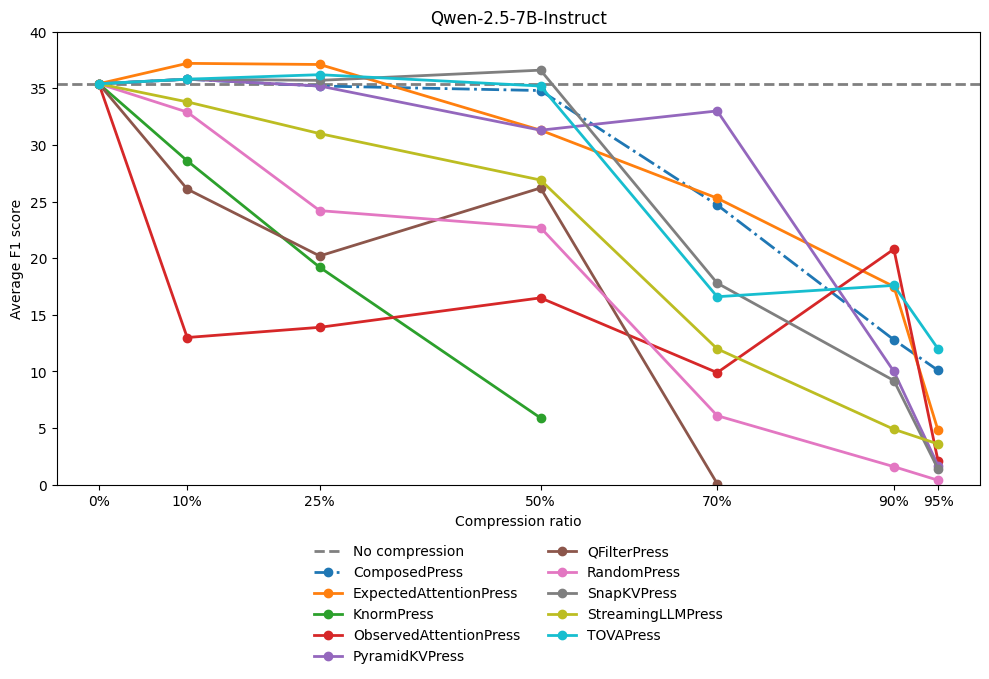

In [ ]:
#!/usr/bin/env python3
"""
plot_kvpress_avg.py

Same as before, but ensures the legend entry for RandomPress
has a dashed line with circle markers.
"""

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D

# ───────── Config ────────────────────────────────────────────────────────────
CSV_PATH    = Path("tables/press_results_f1.csv")
MODEL_NAME  = "Qwen-2.5-7B-Instruct"
BASELINE_F1 = 35.4
RATIO_VALS  = [0, 10, 25, 50, 70, 90, 95]
RATIO_LABELS= [f"{r}%" for r in RATIO_VALS]
COLORS      = plt.rcParams["axes.prop_cycle"].by_key()["color"]
# ──────────────────────────────────────────────────────────────────────────────

# Load & pivot
df = pd.read_csv(CSV_PATH)
df["RatioStr"] = (df["Ratio"] * 100).round(0).astype(int).astype(str) + "%"
pivot = (
    df.pivot_table(index="Press", columns="RatioStr", values="Average", aggfunc="first")
      .reindex(columns=RATIO_LABELS)
      .dropna(how="all")
)

fig, ax = plt.subplots(figsize=(10, 7))

# Baseline
ax.axhline(BASELINE_F1, color="grey", linestyle="--", linewidth=2)

# Plot each press
handles = []
labels  = []
for idx, (tech, row) in enumerate(pivot.iterrows()):
    y = [BASELINE_F1 if i == 0 else row[label] for i, label in enumerate(RATIO_LABELS)]
    line, = ax.plot(
        RATIO_VALS, y,
        color=COLORS[idx % len(COLORS)],
        marker="o",
        linestyle="-." if tech == "ComposedPress" else "-",
        linewidth=2,
    )
    # collect handles & labels for custom legend
    handles.append(line)
    labels.append(tech)

# Add a custom handle for the baseline
baseline_handle = Line2D([0], [0], color="grey", linestyle="--", linewidth=2)
handles.insert(0, baseline_handle)
labels.insert(0, "No compression")

# Aesthetics
ax.set_xticks(RATIO_VALS)
ax.set_xticklabels(RATIO_LABELS)
ax.set_xlabel("Compression ratio")
ax.set_ylabel("Average F1 score")
ax.set_title(MODEL_NAME)
ax.set_ylim(0, 40)

# Build the legend so that RandomPress’s entry shows the dashed line + marker
ax.legend(handles, labels,
          bbox_to_anchor=(0.5, -0.12),
          loc="upper center", ncol=2, frameon=False,
          borderaxespad=0.)

fig.tight_layout()
Path("tables").mkdir(exist_ok=True)
fig.savefig("tables/kvpress_avg.png", dpi=300, bbox_inches="tight")
plt.show()


In [32]:
#!/usr/bin/env python3
import json
import pandas as pd
from pathlib import Path

# Configuration
TEST_SPEED_DIR = Path("test_speed")
OUTPUT_CSV     = Path("tables/avg_time.csv")

# Pretty names for each backend
BACKEND_DISPLAY = {
    "flash_attention_2": "FlashAttention-2",
    "flex_attention":    "Flex Attention",
    "sdpa":              "SDPA",
}

# Ensure output dir exists
OUTPUT_CSV.parent.mkdir(exist_ok=True)

# Gather data
rows = []
for json_file in TEST_SPEED_DIR.glob("*.json"):
    parts = json_file.stem.split("_")
    # find the rate token
    try:
        r_idx = next(i for i,p in enumerate(parts) if p.startswith("r"))
    except StopIteration:
        continue
    raw_backend = "_".join(parts[:r_idx])
    backend     = BACKEND_DISPLAY.get(raw_backend, raw_backend)
    tok_len     = int(parts[-1].replace("tok", ""))

    obj = json.loads(json_file.read_text())
    avg_time = obj.get("avg_time")

    rows.append({
        "Backend": backend,
        "Tokens":  tok_len,
        "AvgTime": avg_time
    })

# Build pivot table
df = pd.DataFrame(rows)
table = df.pivot_table(index="Backend", columns="Tokens", values="AvgTime")
table = table.reindex(columns=sorted(table.columns))

# Round to 3 decimals
table = table.round(3)

# Save CSV with 3-decimal formatting
table.to_csv(OUTPUT_CSV, float_format="%.3f", na_rep="")

# Print table with 3-decimal formatting
print("Average runtime (s) by backend and token length (3 dp):")
print(table.to_string(float_format="%.3f"))
print(f"\nCSV saved to {OUTPUT_CSV}")


Average runtime (s) by backend and token length (3 dp):
Tokens             64    128   256    512
Backend                                  
FlashAttention-2 1.916 3.755 7.190 13.262
Flex Attention   2.706 4.006 7.943 15.708
SDPA             1.956 3.901 6.567 14.482

CSV saved to tables/avg_time.csv


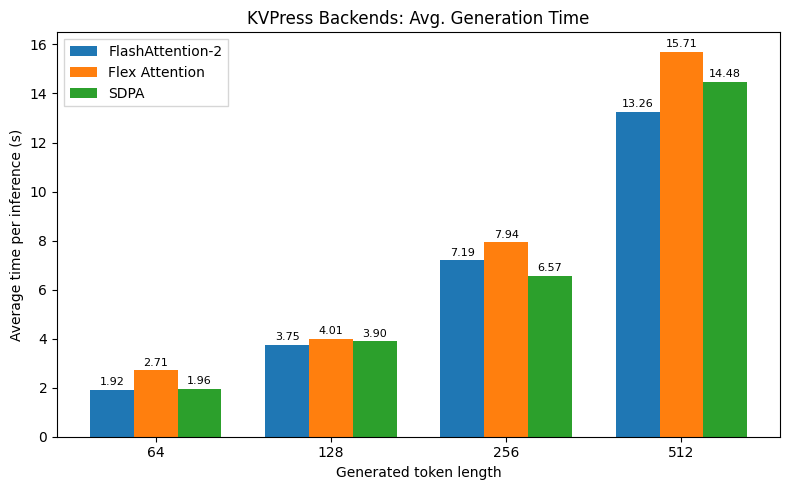

In [44]:
#!/usr/bin/env python3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# ---------- LOAD DATA -------------------------------------------------------
CSV_PATH = Path("tables/avg_time.csv")  # or your actual filename
df = pd.read_csv(CSV_PATH, index_col=0)
df.columns = df.columns.astype(int)
df = df.reindex(sorted(df.columns), axis=1)

# ---------- PLOT: GROUPED BAR CHART WITH LABELS -----------------------------
fig, ax = plt.subplots(figsize=(8, 5))

n_tokens   = len(df.columns)
n_backends = len(df.index)
bar_width  = 1.0 / (n_backends + 1)

x = np.arange(n_tokens)  # positions for each token length

bars = []  # collect bar containers

# draw bars
for i, backend in enumerate(df.index):
    offsets = x - (n_backends-1)/2 * bar_width + i*bar_width
    container = ax.bar(offsets, df.loc[backend], width=bar_width, label=backend)
    bars.append(container)

# annotate each bar
for container in bars:
    for rect in container:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width()/2,
            height + 0.1,           # slight offset above bar
            f"{height:.2f}",        # format with 2 decimals
            ha="center",
            va="bottom",
            fontsize=8
        )

# aesthetics
ax.set_xticks(x)
ax.set_xticklabels([str(t) for t in df.columns])
ax.set_xlabel("Generated token length")
ax.set_ylabel("Average time per inference (s)")
ax.set_title("KVPress Backends: Avg. Generation Time")
ax.legend(loc="upper left", frameon=True, fancybox=False)

fig.tight_layout()

# save & show
OUT_PNG = Path("tables/avg_time_plot.png")
OUT_PNG.parent.mkdir(exist_ok=True)
fig.savefig(OUT_PNG, dpi=300, bbox_inches="tight")
plt.show()
